# Importing

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [ ]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [ ]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)


# SOM

In [ ]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs2 = preprocessing.normalize(inputs2, norm= 'max')
    inputs2 = inputs2.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs2[0,:].size)
    temp_som.fit(inputs2, epochs=100)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [ ]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [ ]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 10179 

The minimum temperature for cluster 0 is 0.57 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.82 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 0.7 g/kg
The mean salinity for cluster 0 is 0.53 g/kg 


The amount of grid boxes for cluster 1 is 13797 

The minimum temperature for cluster 1 is 0.67 degrees Celsius
The maximum temperature for cluster 1 is 0.95 degrees Celsius
The mean temperature for cluster 1 is 0.82 degrees Celsius 

The minimum salinity for cluster 1 is 0.77 g/kg
The maximum salinity for cluster 1 is 0.88 g/kg
The mean salinity for cluster 1 is 0.82 g/kg 


The amount of grid boxes for cluster 2 is 10507 

The minimum temperature for cluster 2 is 0.69 degrees Celsius
The maximum temperature for cluster 2 is 0.88 degrees Celsius
The mean temperature for cluster 2 is 0.78 degrees Celsius 

The minimu

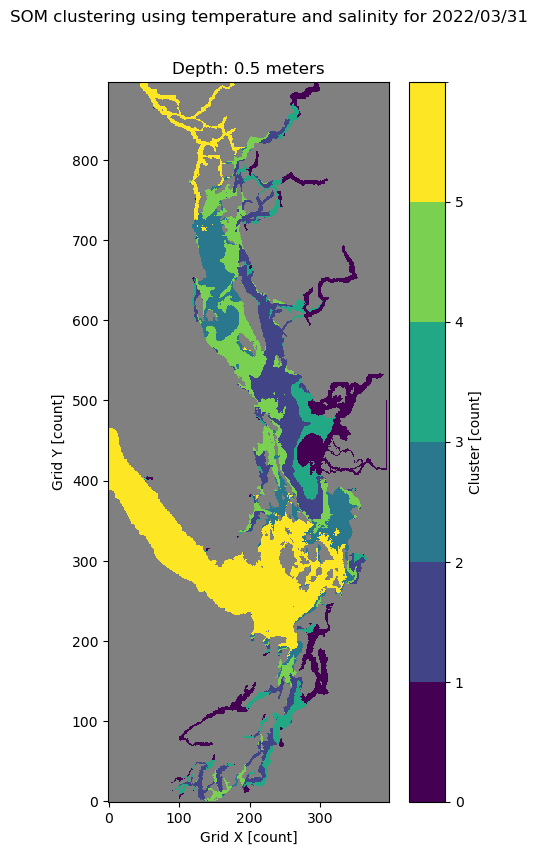

The amount of grid boxes for cluster 0 is 26306 

The minimum temperature for cluster 0 is 0.6 degrees Celsius
The maximum temperature for cluster 0 is 0.82 degrees Celsius
The mean temperature for cluster 0 is 0.72 degrees Celsius 

The minimum salinity for cluster 0 is 0.89 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.97 g/kg 


The amount of grid boxes for cluster 1 is 13186 

The minimum temperature for cluster 1 is 0.69 degrees Celsius
The maximum temperature for cluster 1 is 0.88 degrees Celsius
The mean temperature for cluster 1 is 0.78 degrees Celsius 

The minimum salinity for cluster 1 is 0.83 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.89 g/kg 


The amount of grid boxes for cluster 2 is 7551 

The minimum temperature for cluster 2 is 0.73 degrees Celsius
The maximum temperature for cluster 2 is 0.94 degrees Celsius
The mean temperature for cluster 2 is 0.83 degrees Celsius 

The minimu

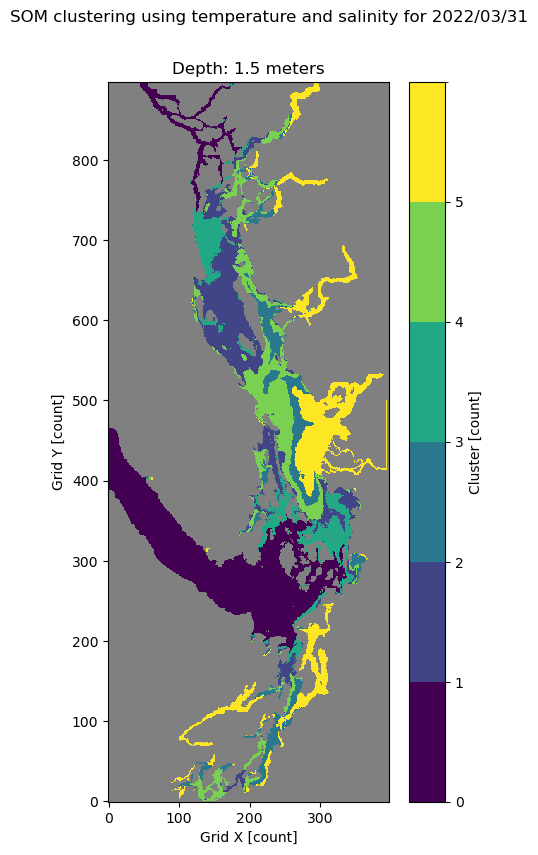

The amount of grid boxes for cluster 0 is 8706 

The minimum temperature for cluster 0 is 0.67 degrees Celsius
The maximum temperature for cluster 0 is 0.85 degrees Celsius
The mean temperature for cluster 0 is 0.75 degrees Celsius 

The minimum salinity for cluster 0 is 0.86 g/kg
The maximum salinity for cluster 0 is 0.98 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 14048 

The minimum temperature for cluster 1 is 0.69 degrees Celsius
The maximum temperature for cluster 1 is 0.91 degrees Celsius
The mean temperature for cluster 1 is 0.8 degrees Celsius 

The minimum salinity for cluster 1 is 0.81 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.85 g/kg 


The amount of grid boxes for cluster 2 is 9951 

The minimum temperature for cluster 2 is 0.56 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.82 degrees Celsius 

The minimum

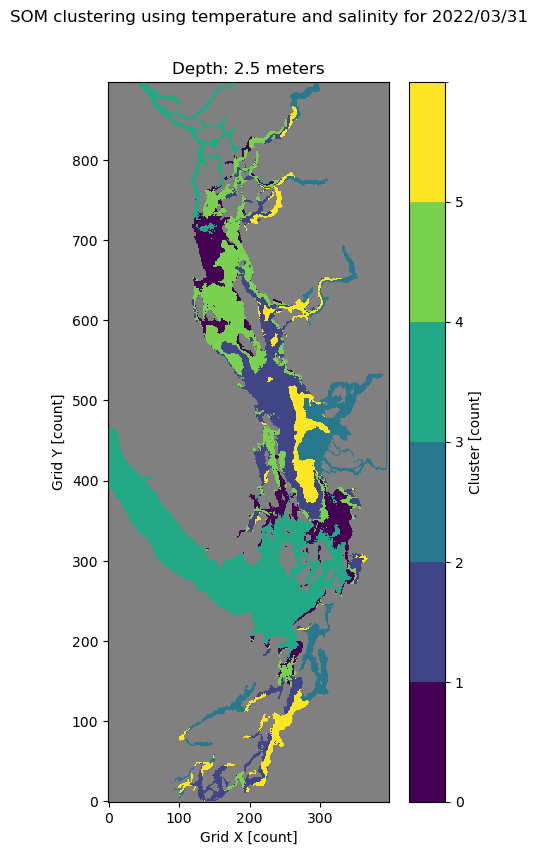

The amount of grid boxes for cluster 0 is 7799 

The minimum temperature for cluster 0 is 0.58 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.81 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 0.81 g/kg
The mean salinity for cluster 0 is 0.65 g/kg 


The amount of grid boxes for cluster 1 is 11507 

The minimum temperature for cluster 1 is 0.69 degrees Celsius
The maximum temperature for cluster 1 is 0.81 degrees Celsius
The mean temperature for cluster 1 is 0.76 degrees Celsius 

The minimum salinity for cluster 1 is 0.79 g/kg
The maximum salinity for cluster 1 is 0.88 g/kg
The mean salinity for cluster 1 is 0.86 g/kg 


The amount of grid boxes for cluster 2 is 8612 

The minimum temperature for cluster 2 is 0.69 degrees Celsius
The maximum temperature for cluster 2 is 0.8 degrees Celsius
The mean temperature for cluster 2 is 0.75 degrees Celsius 

The minimum 

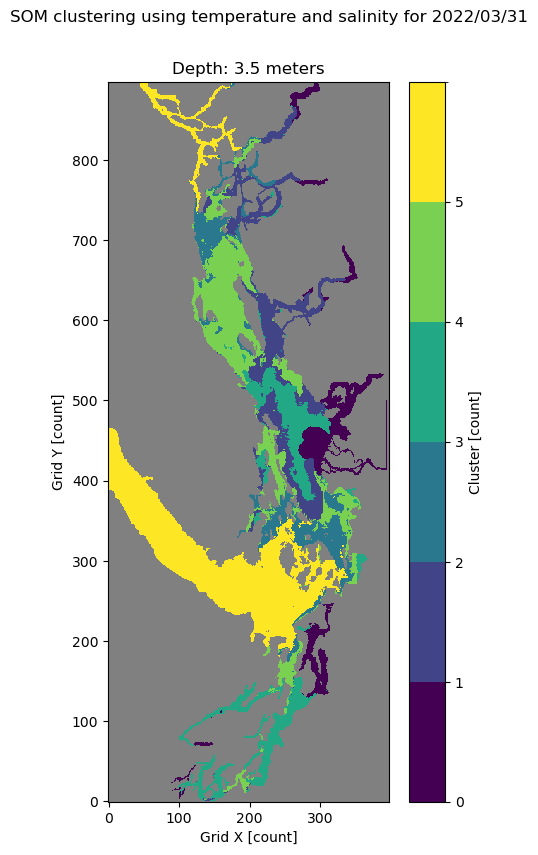

The amount of grid boxes for cluster 0 is 7404 

The minimum temperature for cluster 0 is 0.75 degrees Celsius
The maximum temperature for cluster 0 is 0.88 degrees Celsius
The mean temperature for cluster 0 is 0.79 degrees Celsius 

The minimum salinity for cluster 0 is 0.91 g/kg
The maximum salinity for cluster 0 is 0.98 g/kg
The mean salinity for cluster 0 is 0.93 g/kg 


The amount of grid boxes for cluster 1 is 14117 

The minimum temperature for cluster 1 is 0.77 degrees Celsius
The maximum temperature for cluster 1 is 0.9 degrees Celsius
The mean temperature for cluster 1 is 0.81 degrees Celsius 

The minimum salinity for cluster 1 is 0.86 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.89 g/kg 


The amount of grid boxes for cluster 2 is 12648 

The minimum temperature for cluster 2 is 0.59 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.84 degrees Celsius 

The minimu

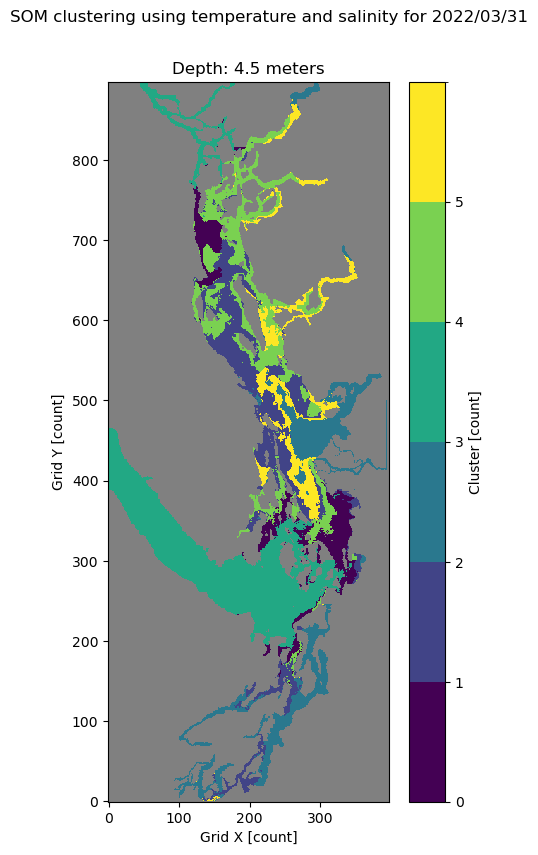

The amount of grid boxes for cluster 0 is 22617 

The minimum temperature for cluster 0 is 0.63 degrees Celsius
The maximum temperature for cluster 0 is 0.81 degrees Celsius
The mean temperature for cluster 0 is 0.76 degrees Celsius 

The minimum salinity for cluster 0 is 0.93 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.97 g/kg 


The amount of grid boxes for cluster 1 is 14115 

The minimum temperature for cluster 1 is 0.71 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.86 g/kg
The maximum salinity for cluster 1 is 0.93 g/kg
The mean salinity for cluster 1 is 0.9 g/kg 


The amount of grid boxes for cluster 2 is 9226 

The minimum temperature for cluster 2 is 0.73 degrees Celsius
The maximum temperature for cluster 2 is 0.83 degrees Celsius
The mean temperature for cluster 2 is 0.8 degrees Celsius 

The minimum 

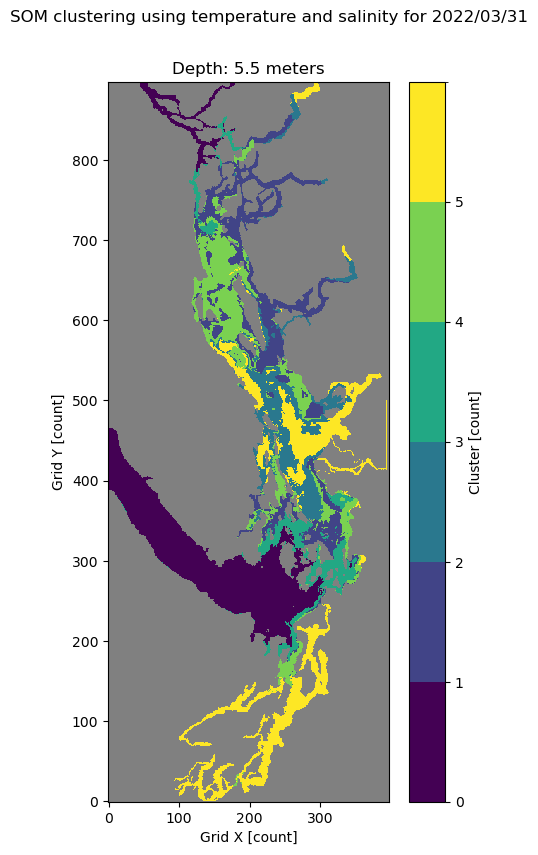

The amount of grid boxes for cluster 0 is 5207 

The minimum temperature for cluster 0 is 0.61 degrees Celsius
The maximum temperature for cluster 0 is 0.89 degrees Celsius
The mean temperature for cluster 0 is 0.78 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 0.88 g/kg
The mean salinity for cluster 0 is 0.77 g/kg 


The amount of grid boxes for cluster 1 is 17562 

The minimum temperature for cluster 1 is 0.71 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.86 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.89 g/kg 


The amount of grid boxes for cluster 2 is 5502 

The minimum temperature for cluster 2 is 0.61 degrees Celsius
The maximum temperature for cluster 2 is 0.8 degrees Celsius
The mean temperature for cluster 2 is 0.77 degrees Celsius 

The minimum 

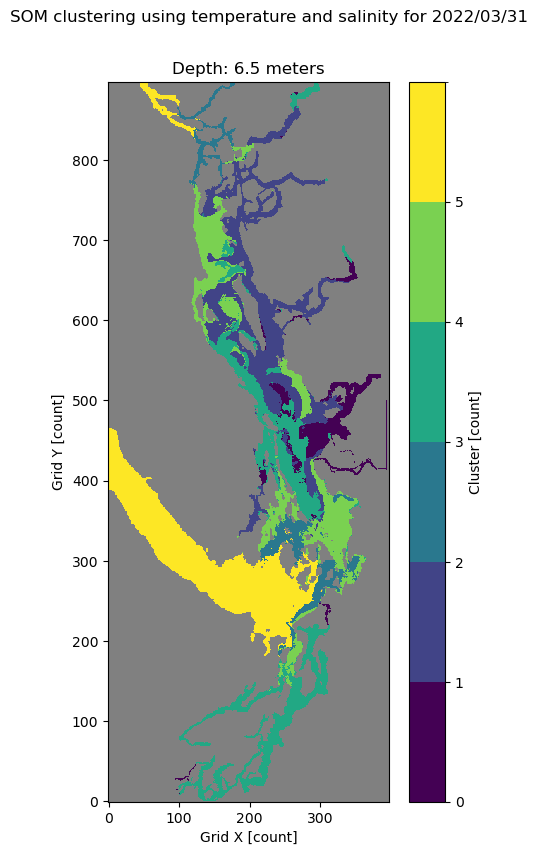

The amount of grid boxes for cluster 0 is 22433 

The minimum temperature for cluster 0 is 0.72 degrees Celsius
The maximum temperature for cluster 0 is 0.85 degrees Celsius
The mean temperature for cluster 0 is 0.77 degrees Celsius 

The minimum salinity for cluster 0 is 0.94 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.97 g/kg 


The amount of grid boxes for cluster 1 is 14254 

The minimum temperature for cluster 1 is 0.77 degrees Celsius
The maximum temperature for cluster 1 is 0.85 degrees Celsius
The mean temperature for cluster 1 is 0.8 degrees Celsius 

The minimum salinity for cluster 1 is 0.9 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 15730 

The minimum temperature for cluster 2 is 0.79 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.84 degrees Celsius 

The minimum

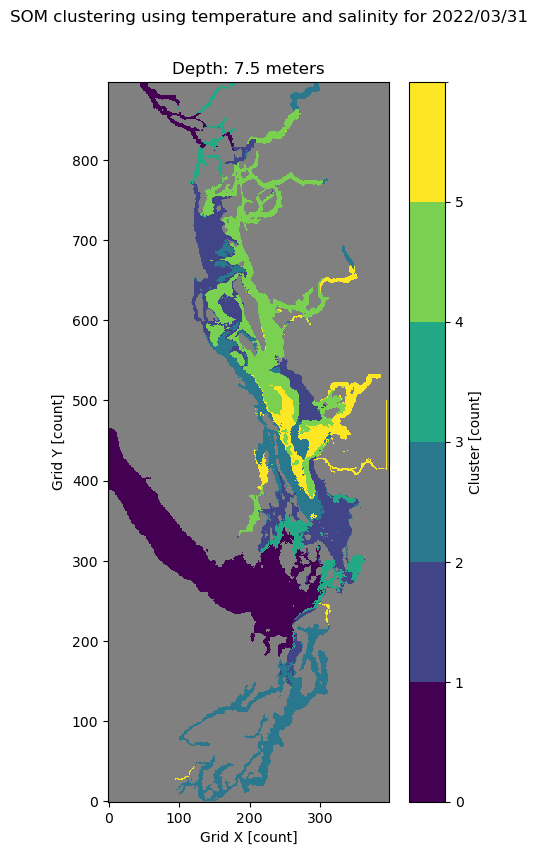

The amount of grid boxes for cluster 0 is 10903 

The minimum temperature for cluster 0 is 0.81 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.85 degrees Celsius 

The minimum salinity for cluster 0 is 0.62 g/kg
The maximum salinity for cluster 0 is 0.95 g/kg
The mean salinity for cluster 0 is 0.89 g/kg 


The amount of grid boxes for cluster 1 is 11171 

The minimum temperature for cluster 1 is 0.78 degrees Celsius
The maximum temperature for cluster 1 is 0.85 degrees Celsius
The mean temperature for cluster 1 is 0.8 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.97 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 21036 

The minimum temperature for cluster 2 is 0.72 degrees Celsius
The maximum temperature for cluster 2 is 0.83 degrees Celsius
The mean temperature for cluster 2 is 0.77 degrees Celsius 

The minim

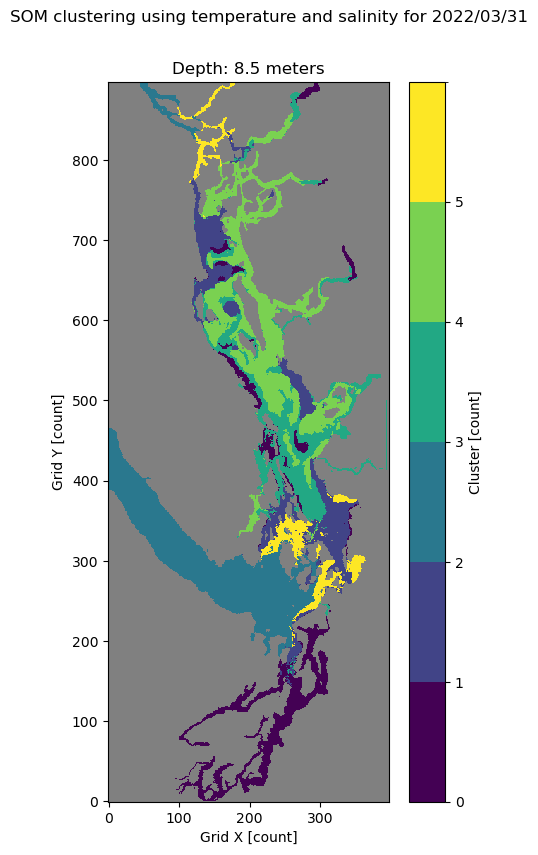

The amount of grid boxes for cluster 0 is 13093 

The minimum temperature for cluster 0 is 0.78 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.84 degrees Celsius 

The minimum salinity for cluster 0 is 0.8 g/kg
The maximum salinity for cluster 0 is 0.93 g/kg
The mean salinity for cluster 0 is 0.89 g/kg 


The amount of grid boxes for cluster 1 is 18505 

The minimum temperature for cluster 1 is 0.78 degrees Celsius
The maximum temperature for cluster 1 is 0.85 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.88 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 6867 

The minimum temperature for cluster 2 is 0.74 degrees Celsius
The maximum temperature for cluster 2 is 0.83 degrees Celsius
The mean temperature for cluster 2 is 0.78 degrees Celsius 

The minimu

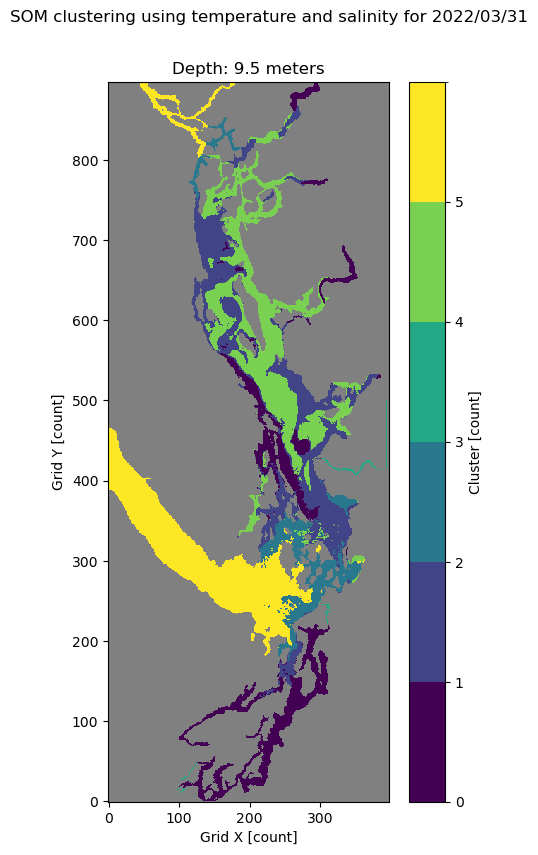

The amount of grid boxes for cluster 0 is 11560 

The minimum temperature for cluster 0 is 0.8 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.84 degrees Celsius 

The minimum salinity for cluster 0 is 0.67 g/kg
The maximum salinity for cluster 0 is 0.95 g/kg
The mean salinity for cluster 0 is 0.89 g/kg 


The amount of grid boxes for cluster 1 is 14050 

The minimum temperature for cluster 1 is 0.77 degrees Celsius
The maximum temperature for cluster 1 is 0.83 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 20458 

The minimum temperature for cluster 2 is 0.71 degrees Celsius
The maximum temperature for cluster 2 is 0.81 degrees Celsius
The mean temperature for cluster 2 is 0.76 degrees Celsius 

The minim

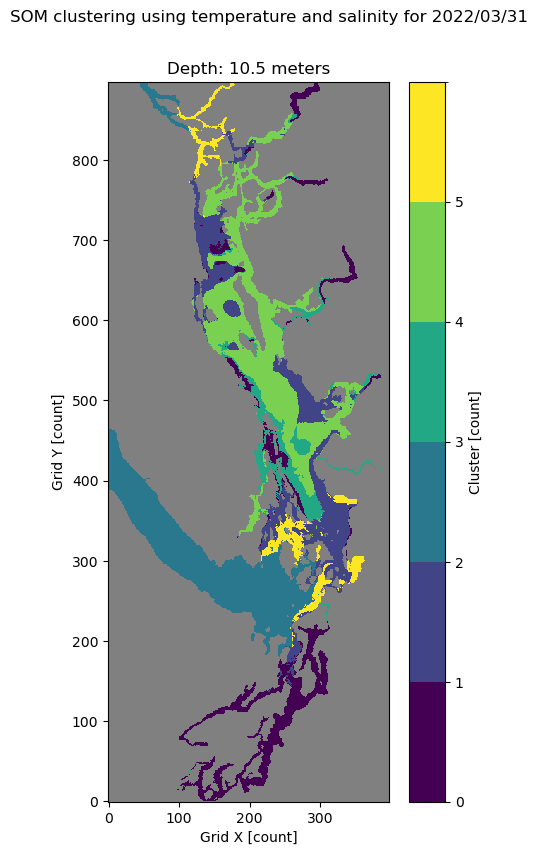

The amount of grid boxes for cluster 0 is 4181 

The minimum temperature for cluster 0 is 0.61 degrees Celsius
The maximum temperature for cluster 0 is 0.77 degrees Celsius
The mean temperature for cluster 0 is 0.75 degrees Celsius 

The minimum salinity for cluster 0 is 0.92 g/kg
The maximum salinity for cluster 0 is 0.95 g/kg
The mean salinity for cluster 0 is 0.94 g/kg 


The amount of grid boxes for cluster 1 is 20059 

The minimum temperature for cluster 1 is 0.71 degrees Celsius
The maximum temperature for cluster 1 is 0.77 degrees Celsius
The mean temperature for cluster 1 is 0.76 degrees Celsius 

The minimum salinity for cluster 1 is 0.88 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.9 g/kg 


The amount of grid boxes for cluster 2 is 11513 

The minimum temperature for cluster 2 is 0.61 degrees Celsius
The maximum temperature for cluster 2 is 0.8 degrees Celsius
The mean temperature for cluster 2 is 0.78 degrees Celsius 

The minimu

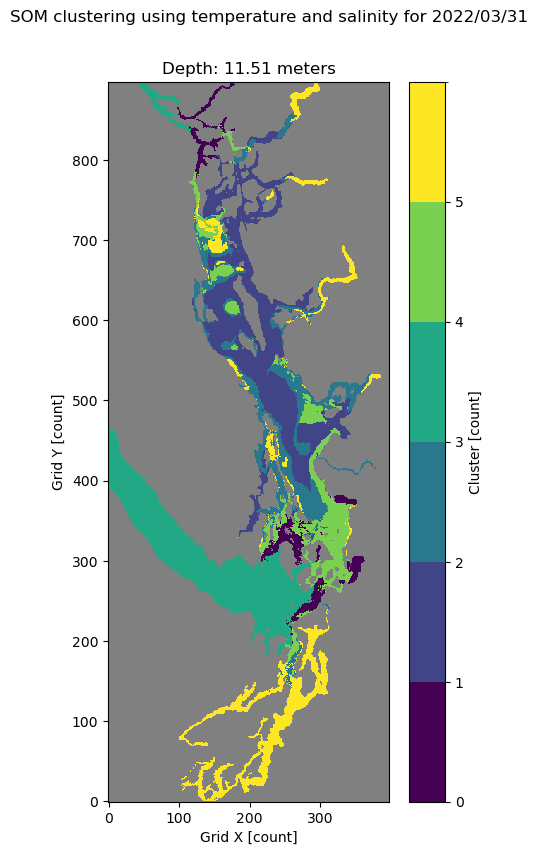

The amount of grid boxes for cluster 0 is 19799 

The minimum temperature for cluster 0 is 0.69 degrees Celsius
The maximum temperature for cluster 0 is 0.79 degrees Celsius
The mean temperature for cluster 0 is 0.75 degrees Celsius 

The minimum salinity for cluster 0 is 0.95 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.97 g/kg 


The amount of grid boxes for cluster 1 is 13271 

The minimum temperature for cluster 1 is 0.76 degrees Celsius
The maximum temperature for cluster 1 is 0.81 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 13020 

The minimum temperature for cluster 2 is 0.78 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.83 degrees Celsius 

The minim

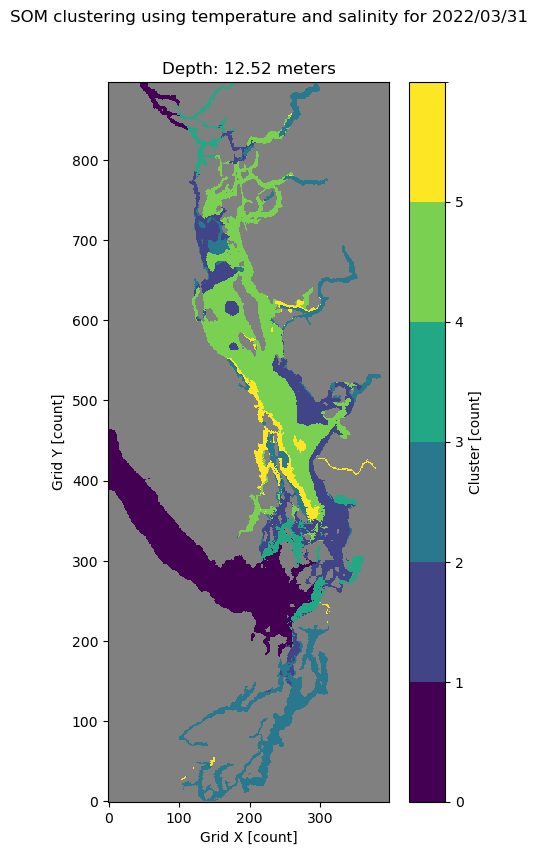

The amount of grid boxes for cluster 0 is 10111 

The minimum temperature for cluster 0 is 0.78 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.84 degrees Celsius 

The minimum salinity for cluster 0 is 0.75 g/kg
The maximum salinity for cluster 0 is 0.94 g/kg
The mean salinity for cluster 0 is 0.9 g/kg 


The amount of grid boxes for cluster 1 is 15867 

The minimum temperature for cluster 1 is 0.76 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 19764 

The minimum temperature for cluster 2 is 0.69 degrees Celsius
The maximum temperature for cluster 2 is 0.79 degrees Celsius
The mean temperature for cluster 2 is 0.74 degrees Celsius 

The minimu

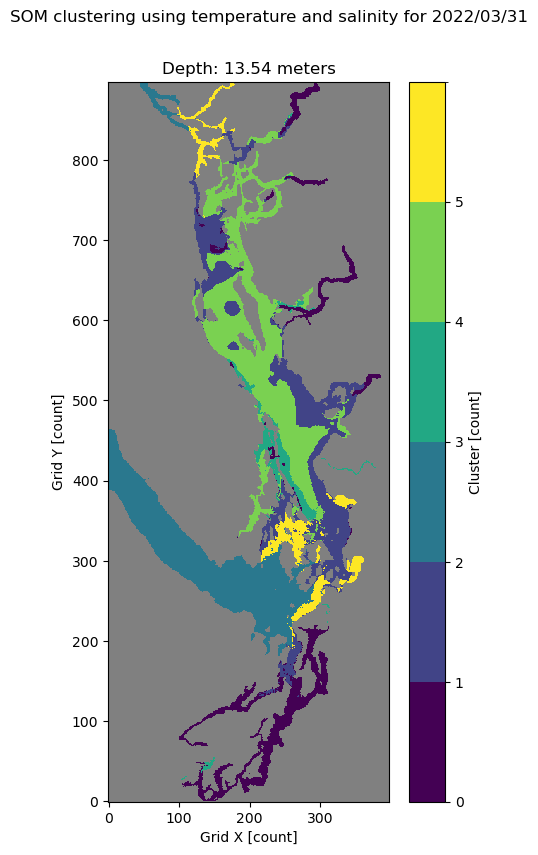

The amount of grid boxes for cluster 0 is 9388 

The minimum temperature for cluster 0 is 0.79 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.84 degrees Celsius 

The minimum salinity for cluster 0 is 0.71 g/kg
The maximum salinity for cluster 0 is 0.94 g/kg
The mean salinity for cluster 0 is 0.9 g/kg 


The amount of grid boxes for cluster 1 is 9633 

The minimum temperature for cluster 1 is 0.76 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.95 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 21210 

The minimum temperature for cluster 2 is 0.68 degrees Celsius
The maximum temperature for cluster 2 is 0.78 degrees Celsius
The mean temperature for cluster 2 is 0.74 degrees Celsius 

The minimum 

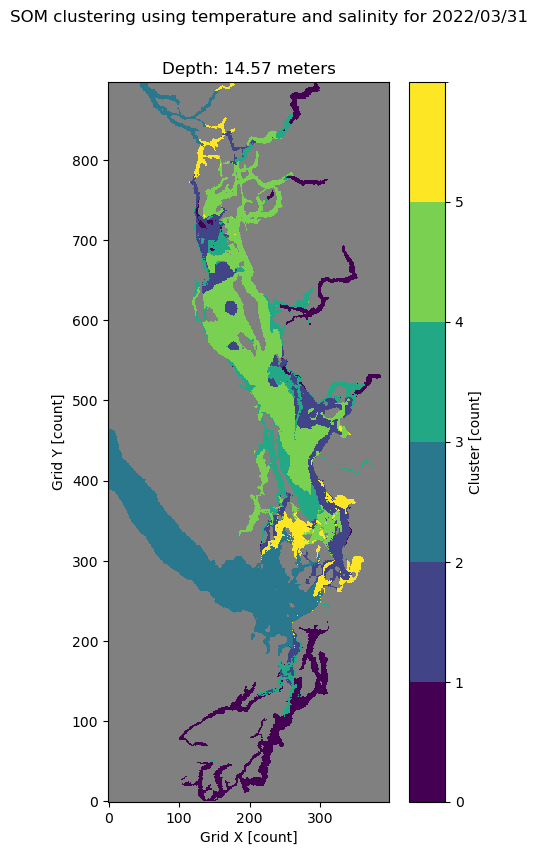

The amount of grid boxes for cluster 0 is 10400 

The minimum temperature for cluster 0 is 0.79 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.84 degrees Celsius 

The minimum salinity for cluster 0 is 0.71 g/kg
The maximum salinity for cluster 0 is 0.94 g/kg
The mean salinity for cluster 0 is 0.9 g/kg 


The amount of grid boxes for cluster 1 is 7424 

The minimum temperature for cluster 1 is 0.76 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.94 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 20932 

The minimum temperature for cluster 2 is 0.65 degrees Celsius
The maximum temperature for cluster 2 is 0.78 degrees Celsius
The mean temperature for cluster 2 is 0.74 degrees Celsius 

The minimum

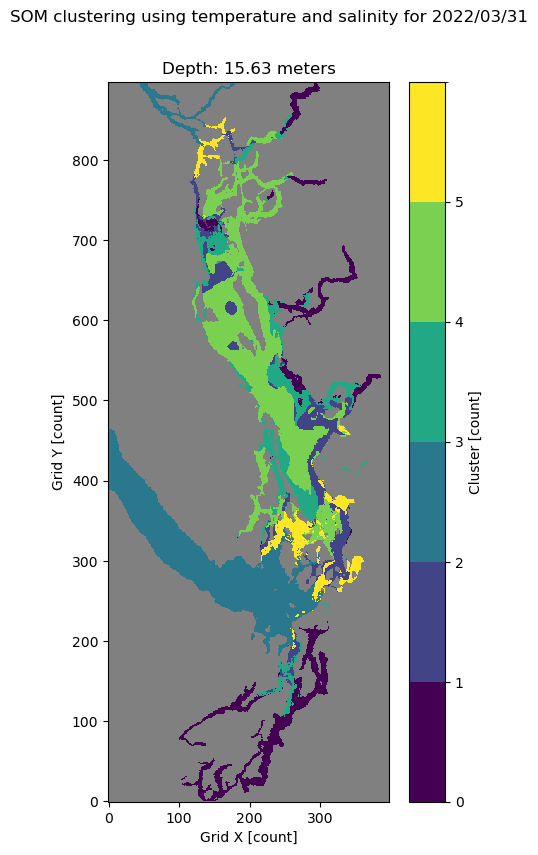

The amount of grid boxes for cluster 0 is 5066 

The minimum temperature for cluster 0 is 0.71 degrees Celsius
The maximum temperature for cluster 0 is 0.77 degrees Celsius
The mean temperature for cluster 0 is 0.75 degrees Celsius 

The minimum salinity for cluster 0 is 0.92 g/kg
The maximum salinity for cluster 0 is 0.95 g/kg
The mean salinity for cluster 0 is 0.94 g/kg 


The amount of grid boxes for cluster 1 is 21612 

The minimum temperature for cluster 1 is 0.7 degrees Celsius
The maximum temperature for cluster 1 is 0.77 degrees Celsius
The mean temperature for cluster 1 is 0.75 degrees Celsius 

The minimum salinity for cluster 1 is 0.88 g/kg
The maximum salinity for cluster 1 is 0.93 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 11153 

The minimum temperature for cluster 2 is 0.62 degrees Celsius
The maximum temperature for cluster 2 is 0.8 degrees Celsius
The mean temperature for cluster 2 is 0.78 degrees Celsius 

The minimu

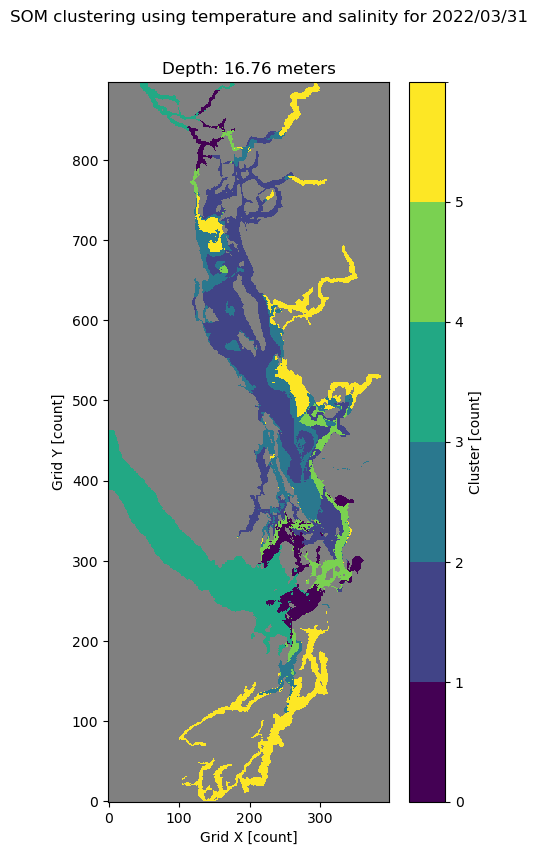

The amount of grid boxes for cluster 0 is 10146 

The minimum temperature for cluster 0 is 0.63 degrees Celsius
The maximum temperature for cluster 0 is 0.8 degrees Celsius
The mean temperature for cluster 0 is 0.79 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 0.94 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 22336 

The minimum temperature for cluster 1 is 0.62 degrees Celsius
The maximum temperature for cluster 1 is 0.78 degrees Celsius
The mean temperature for cluster 1 is 0.76 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 4723 

The minimum temperature for cluster 2 is 0.73 degrees Celsius
The maximum temperature for cluster 2 is 0.77 degrees Celsius
The mean temperature for cluster 2 is 0.76 degrees Celsius 

The minimum

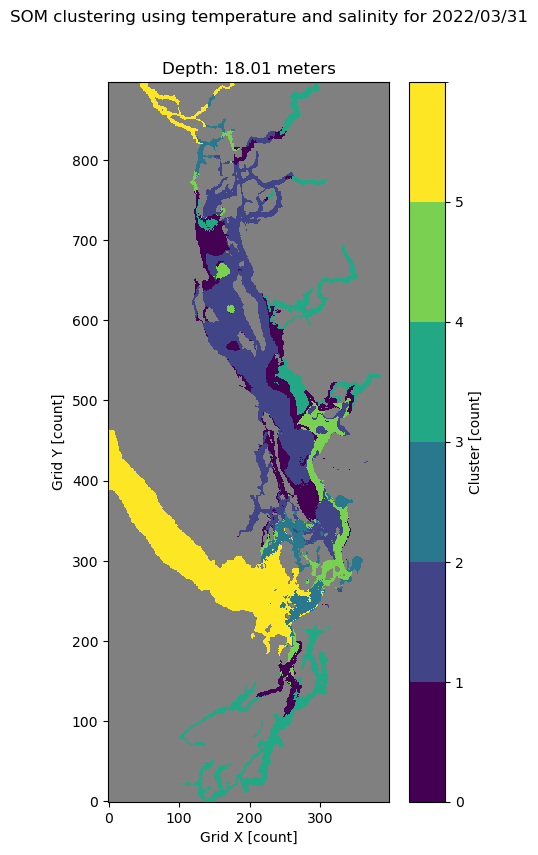

The amount of grid boxes for cluster 0 is 5571 

The minimum temperature for cluster 0 is 0.71 degrees Celsius
The maximum temperature for cluster 0 is 0.78 degrees Celsius
The mean temperature for cluster 0 is 0.76 degrees Celsius 

The minimum salinity for cluster 0 is 0.92 g/kg
The maximum salinity for cluster 0 is 0.95 g/kg
The mean salinity for cluster 0 is 0.94 g/kg 


The amount of grid boxes for cluster 1 is 21120 

The minimum temperature for cluster 1 is 0.71 degrees Celsius
The maximum temperature for cluster 1 is 0.78 degrees Celsius
The mean temperature for cluster 1 is 0.77 degrees Celsius 

The minimum salinity for cluster 1 is 0.88 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 11735 

The minimum temperature for cluster 2 is 0.63 degrees Celsius
The maximum temperature for cluster 2 is 0.81 degrees Celsius
The mean temperature for cluster 2 is 0.79 degrees Celsius 

The mini

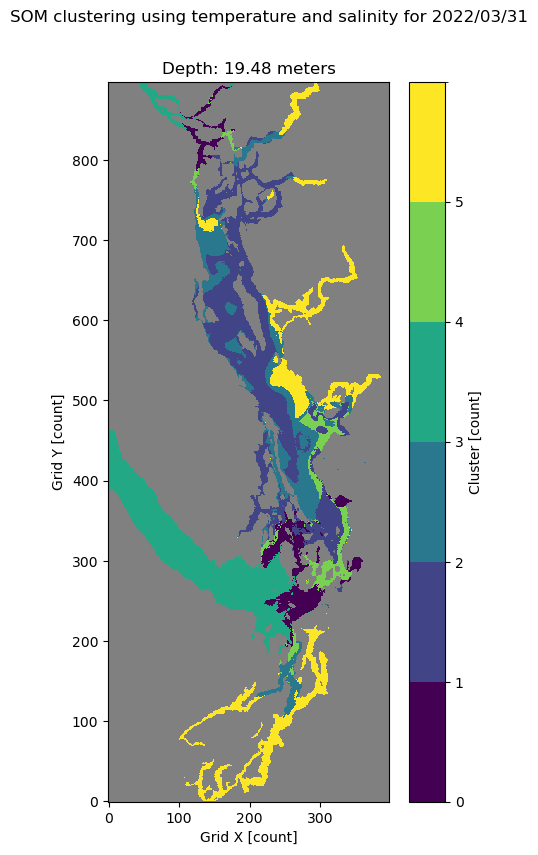

The amount of grid boxes for cluster 0 is 8689 

The minimum temperature for cluster 0 is 0.79 degrees Celsius
The maximum temperature for cluster 0 is 0.82 degrees Celsius
The mean temperature for cluster 0 is 0.8 degrees Celsius 

The minimum salinity for cluster 0 is 0.85 g/kg
The maximum salinity for cluster 0 is 0.93 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 22435 

The minimum temperature for cluster 1 is 0.75 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.78 degrees Celsius 

The minimum salinity for cluster 1 is 0.87 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 5040 

The minimum temperature for cluster 2 is 0.72 degrees Celsius
The maximum temperature for cluster 2 is 0.79 degrees Celsius
The mean temperature for cluster 2 is 0.77 degrees Celsius 

The minimum

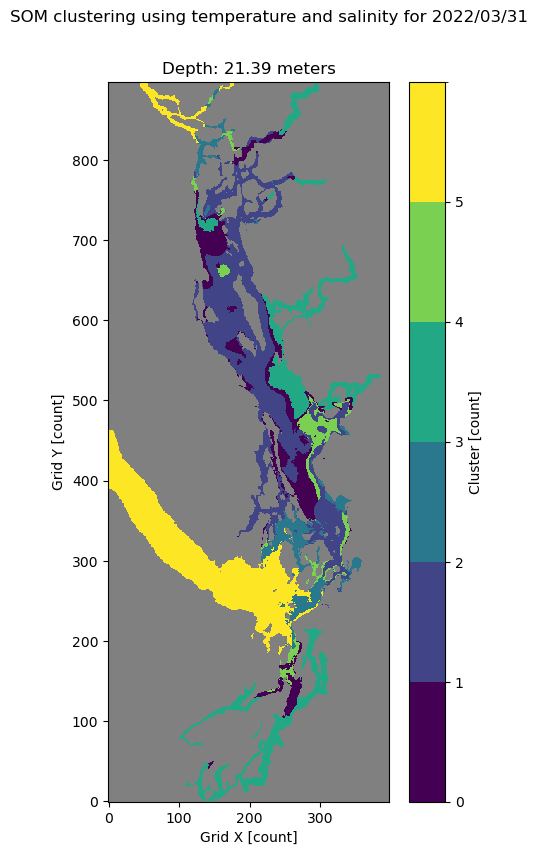

The amount of grid boxes for cluster 0 is 9207 

The minimum temperature for cluster 0 is 0.84 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.88 degrees Celsius 

The minimum salinity for cluster 0 is 0.82 g/kg
The maximum salinity for cluster 0 is 0.93 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 2134 

The minimum temperature for cluster 1 is 0.79 degrees Celsius
The maximum temperature for cluster 1 is 0.82 degrees Celsius
The mean temperature for cluster 1 is 0.8 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.94 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 18161 

The minimum temperature for cluster 2 is 0.7 degrees Celsius
The maximum temperature for cluster 2 is 0.8 degrees Celsius
The mean temperature for cluster 2 is 0.76 degrees Celsius 

The minimum s

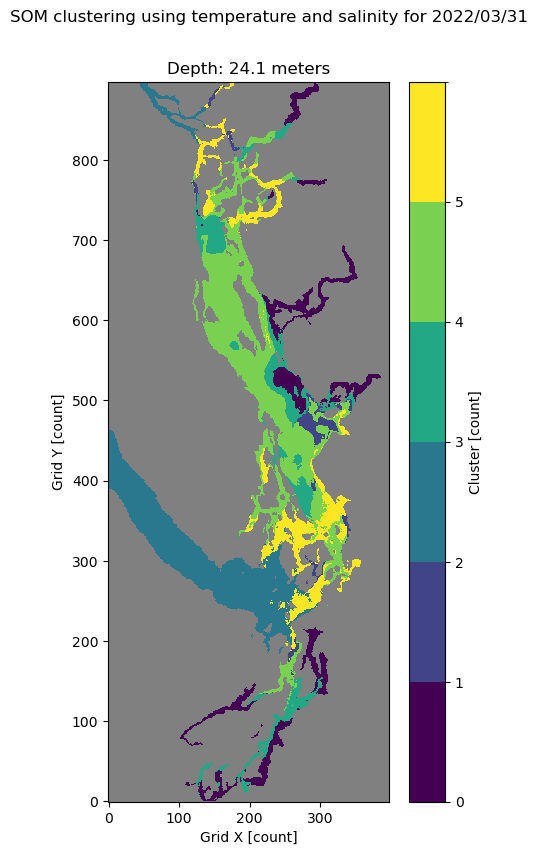

The amount of grid boxes for cluster 0 is 13023 

The minimum temperature for cluster 0 is 0.82 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.87 degrees Celsius 

The minimum salinity for cluster 0 is 0.82 g/kg
The maximum salinity for cluster 0 is 0.93 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 2398 

The minimum temperature for cluster 1 is 0.79 degrees Celsius
The maximum temperature for cluster 1 is 0.82 degrees Celsius
The mean temperature for cluster 1 is 0.8 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.93 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 17114 

The minimum temperature for cluster 2 is 0.7 degrees Celsius
The maximum temperature for cluster 2 is 0.79 degrees Celsius
The mean temperature for cluster 2 is 0.76 degrees Celsius 

The minimum

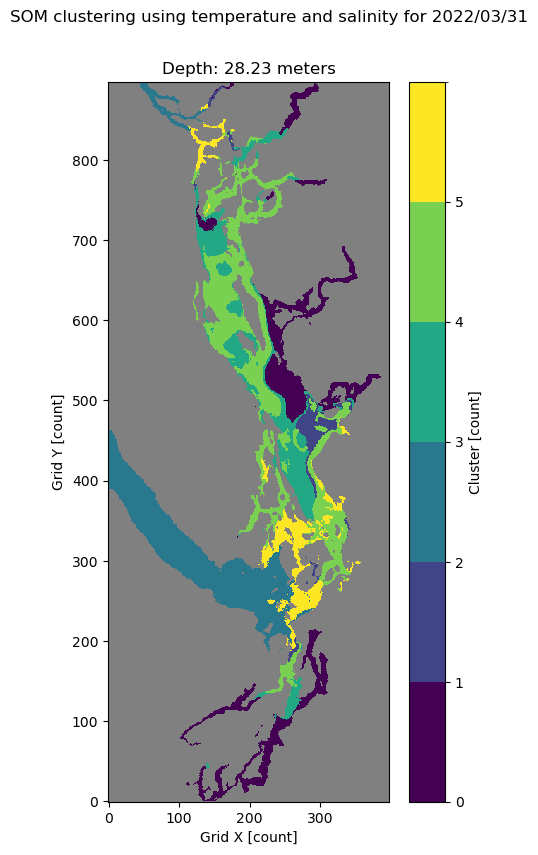

The amount of grid boxes for cluster 0 is 9824 

The minimum temperature for cluster 0 is 0.83 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.88 degrees Celsius 

The minimum salinity for cluster 0 is 0.84 g/kg
The maximum salinity for cluster 0 is 0.93 g/kg
The mean salinity for cluster 0 is 0.91 g/kg 


The amount of grid boxes for cluster 1 is 216 

The minimum temperature for cluster 1 is 0.78 degrees Celsius
The maximum temperature for cluster 1 is 0.82 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.93 g/kg
The mean salinity for cluster 1 is 0.92 g/kg 


The amount of grid boxes for cluster 2 is 15979 

The minimum temperature for cluster 2 is 0.7 degrees Celsius
The maximum temperature for cluster 2 is 0.77 degrees Celsius
The mean temperature for cluster 2 is 0.75 degrees Celsius 

The minimum 

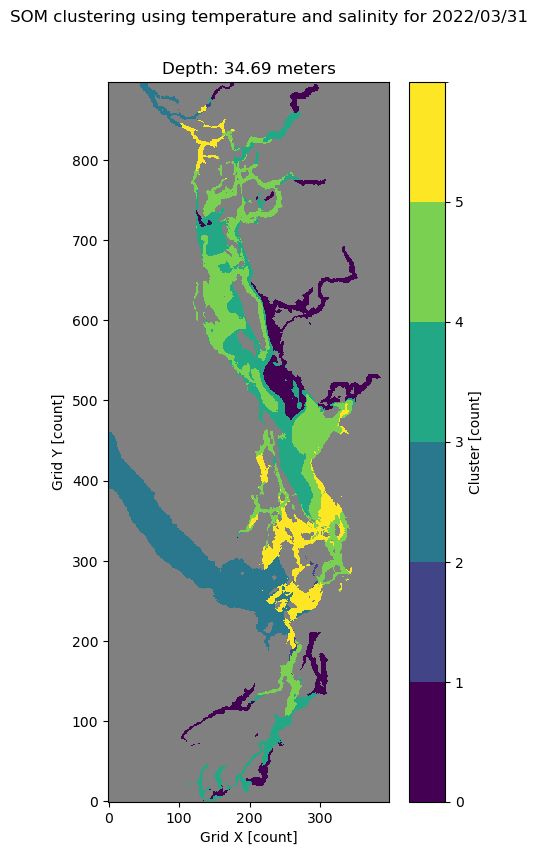

The amount of grid boxes for cluster 0 is 15332 

The minimum temperature for cluster 0 is 0.8 degrees Celsius
The maximum temperature for cluster 0 is 0.84 degrees Celsius
The mean temperature for cluster 0 is 0.82 degrees Celsius 

The minimum salinity for cluster 0 is 0.82 g/kg
The maximum salinity for cluster 0 is 0.92 g/kg
The mean salinity for cluster 0 is 0.9 g/kg 


The amount of grid boxes for cluster 1 is 13014 

The minimum temperature for cluster 1 is 0.77 degrees Celsius
The maximum temperature for cluster 1 is 0.81 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.87 g/kg
The maximum salinity for cluster 1 is 0.92 g/kg
The mean salinity for cluster 1 is 0.9 g/kg 


The amount of grid boxes for cluster 2 is 9548 

The minimum temperature for cluster 2 is 0.73 degrees Celsius
The maximum temperature for cluster 2 is 0.78 degrees Celsius
The mean temperature for cluster 2 is 0.76 degrees Celsius 

The minimum

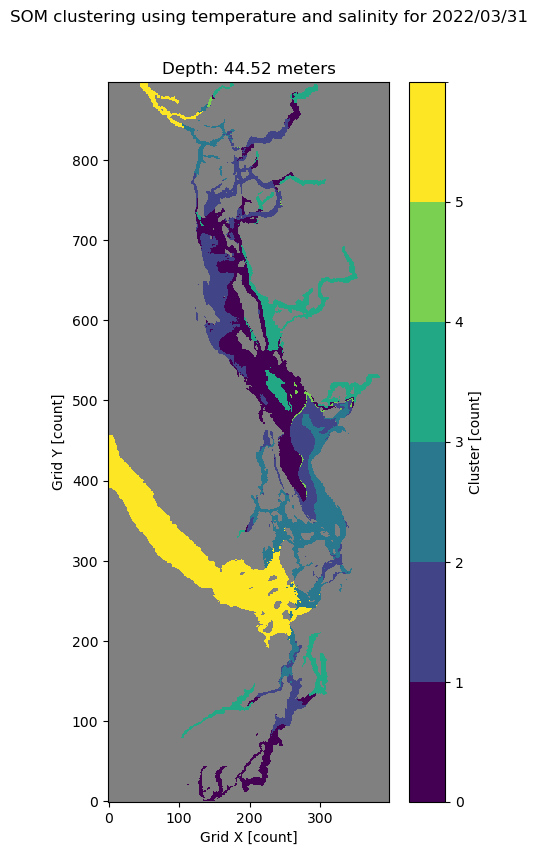

The amount of grid boxes for cluster 0 is 11871 

The minimum temperature for cluster 0 is 0.69 degrees Celsius
The maximum temperature for cluster 0 is 0.74 degrees Celsius
The mean temperature for cluster 0 is 0.72 degrees Celsius 

The minimum salinity for cluster 0 is 0.93 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.97 g/kg 


The amount of grid boxes for cluster 1 is 26 

The minimum temperature for cluster 1 is 0.78 degrees Celsius
The maximum temperature for cluster 1 is 0.8 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.9 g/kg
The maximum salinity for cluster 1 is 0.91 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 12172 

The minimum temperature for cluster 2 is 0.82 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.86 degrees Celsius 

The minimum sa

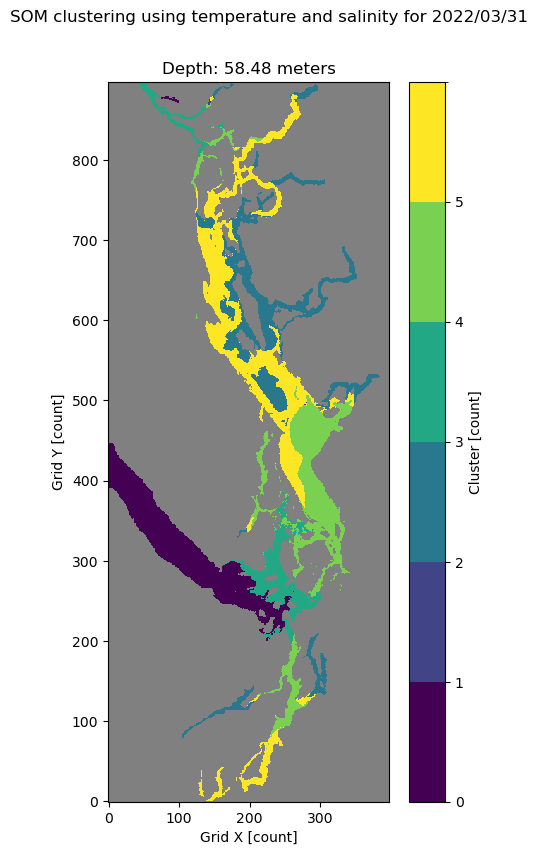

The amount of grid boxes for cluster 0 is 16633 

The minimum temperature for cluster 0 is 0.82 degrees Celsius
The maximum temperature for cluster 0 is 1.0 degrees Celsius
The mean temperature for cluster 0 is 0.85 degrees Celsius 

The minimum salinity for cluster 0 is 0.88 g/kg
The maximum salinity for cluster 0 is 0.91 g/kg
The mean salinity for cluster 0 is 0.9 g/kg 


The amount of grid boxes for cluster 1 is 3 

The minimum temperature for cluster 1 is 0.79 degrees Celsius
The maximum temperature for cluster 1 is 0.79 degrees Celsius
The mean temperature for cluster 1 is 0.79 degrees Celsius 

The minimum salinity for cluster 1 is 0.91 g/kg
The maximum salinity for cluster 1 is 0.91 g/kg
The mean salinity for cluster 1 is 0.91 g/kg 


The amount of grid boxes for cluster 2 is 11584 

The minimum temperature for cluster 2 is 0.69 degrees Celsius
The maximum temperature for cluster 2 is 0.73 degrees Celsius
The mean temperature for cluster 2 is 0.7 degrees Celsius 

The minimum sa

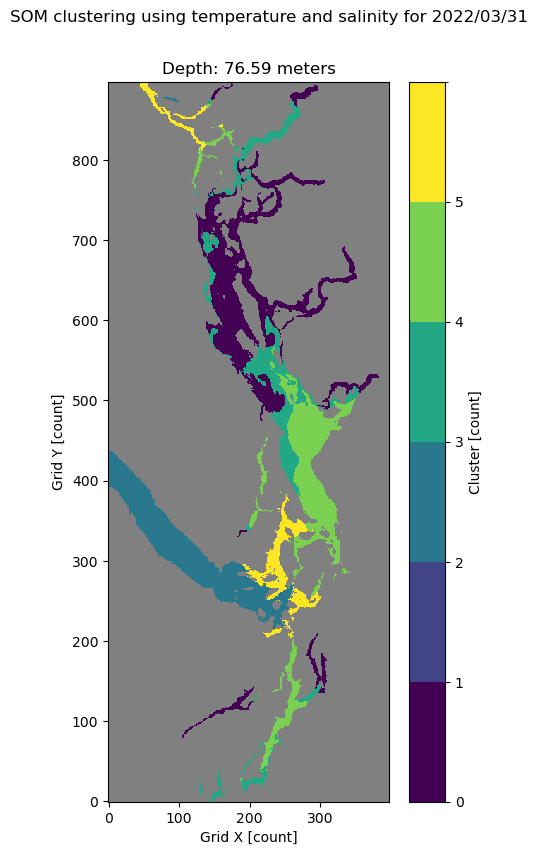

The amount of grid boxes for cluster 0 is 10441 

The minimum temperature for cluster 0 is 0.67 degrees Celsius
The maximum temperature for cluster 0 is 0.72 degrees Celsius
The mean temperature for cluster 0 is 0.69 degrees Celsius 

The minimum salinity for cluster 0 is 0.94 g/kg
The maximum salinity for cluster 0 is 1.0 g/kg
The mean salinity for cluster 0 is 0.98 g/kg 


The amount of grid boxes for cluster 2 is 2552 

The minimum temperature for cluster 2 is 0.82 degrees Celsius
The maximum temperature for cluster 2 is 1.0 degrees Celsius
The mean temperature for cluster 2 is 0.85 degrees Celsius 

The minimum salinity for cluster 2 is 0.88 g/kg
The maximum salinity for cluster 2 is 0.91 g/kg
The mean salinity for cluster 2 is 0.9 g/kg 


The amount of grid boxes for cluster 3 is 13403 

The minimum temperature for cluster 3 is 0.69 degrees Celsius
The maximum temperature for cluster 3 is 0.75 degrees Celsius
The mean temperature for cluster 3 is 0.73 degrees Celsius 

The minimum

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
